# SimpleMOC
---
## Parameters
```
Compiler = 'clang 5.0.1'
Build_Flags = '-g -Ofast -march=native -ffast-math -ftree-vectorize -fopenmp -lm'
Run_Flags = '-t <# of threads>'
```

#### NOTE: Compiler specific directives for Intel and IBM Compilers
```c
#ifdef INTEL
#pragma simd
#elif defined IBM
#pragma simd_level(10)
#endif
```

---
## Scaling

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

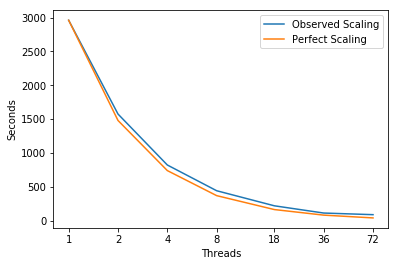

In [4]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads, [2960.0, 1575.0, 822.5, 442.5, 220.0, 113.05555555555556, 89.02777777777777],
        label='Observed Scaling')
ax.plot(Threads, [2960.0, 1480.0, 740.0, 370.0, 164.44444444444446, 82.22222222222223, 41.111111111111114],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Roofline - Intel Haswell - 72 Threads - 36 Cores - 2 Sockets - 2301.0 Mhz
| GB/sec | L1 B/W | L2 B/W | L3 B/W | DRAM B/W |
|:---------|:------:|:------:|:------:|:--------:|
| **1 Thread**   | 142.7  |  45.0  |  33.7  |   16.0   |
|**72 Threads**  | 2399.9  |  784.0  |  564.8  |   60.4  |

---
## Program Aggregate
| Experiment Aggregate Metrics | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-----------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                            |  100.0 %   |        1.4          |         1.9% |         85.7% |     17.0% |                0.71     |        5.2% |        5.9%  |       2.1%    |
| 72                           |  100.0 %   |        2.2          |         2.7% |         63.7% |     21.4% |                0.65     |       14.3% |       12.7%  |      25.4%    |

---
## attenuate_fluxes( )
| attenuate_fluxes | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-----------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                |  78.9 %   |        1.3          |         2.0% |         85.7% |     14.6% |                0.65     |        5.2% |        5.9%  |       1.8%    |
| 72               |  75.7 %   |        2.0          |         2.9% |         63.7% |     21.2% |                0.61     |       14.4% |       12.7%  |      25.3%    |
```c
  14 void attenuate_fluxes( Track * track, bool forward, Source * QSR, Input * I_in,
  15                 Params * params_in, float ds, float mu, float az_weight,
  16                 AttenuateVars * A )
  17 {
  18         Input I = *I_in;
  19         Params params = *params_in;
  20 
  21         // unload attenuate vars
  22         float * restrict q0 = A->q0;
  23         float *  restrict q1 = A->q1;
  24         float *  restrict q2 = A->q2;
  25         float *  restrict sigT = A->sigT;
  26         float *  restrict tau = A->tau;
  27         float *  restrict sigT2 = A->sigT2;
  28         float *  restrict expVal = A->expVal;
  29         float *  restrict reuse = A->reuse;
  30         float *  restrict flux_integral = A->flux_integral;
  31         float *  restrict tally = A->tally;
  32         float *  restrict t1 = A->t1;
  33         float *  restrict t2 = A->t2;
  34         float *  restrict t3 = A->t3;
  35         float *  restrict t4 = A->t4;
  36 
  37         // compute fine axial interval spacing
  38         float dz = I.height / (I.fai * I.decomp_assemblies_ax * I.cai);
  39 
  40         // compute z height in cell
  41         float zin = track->z_height - dz *
  42                 ( (int)( track->z_height / dz ) + 0.5f );
  43 
  44         // compute fine axial region ID
  45         int fine_id = (int) ( track->z_height / dz ) % I.fai;
  46 
  47         // compute weight (azimuthal * polar)
  48         // NOTE: real app would also have volume weight component
  49         float weight = track->p_weight * az_weight;
  50         float mu2 = mu * mu;
  51 
  52         // load fine source region flux vector
  53         float * FSR_flux = QSR -> fine_flux[fine_id];
  54 
  55         if( fine_id == 0 )
  56         {
  57                 // adjust z height to account for edge
  58                 zin -= dz;
  59 
  60                 // cycle over energy groups
  61                 #ifdef INTEL
  62                 #pragma simd
  63                 #elif defined IBM
  64                 #pragma simd_level(10)
  65                 #endif
  66                 for( int g = 0; g < I.n_egroups; g++)
  67                 {
  68                         // load neighboring sources
  69                         float y1 = QSR->fine_source[fine_id][g];
  70                         float y2 = QSR->fine_source[fine_id+1][g];
  71                         float y3 = QSR->fine_source[fine_id+2][g];
  72 
  73                         // do quadratic "fitting"
  74                         float c0 = y2;
  75                         float c1 = (y1 - y3) / (2.f*dz);
  76                         float c2 = (y1 - 2.f*y2 + y3) / (2.f*dz*dz);
  77 
  78                         // calculate q0, q1, q2
  79                         q0[g] = c0 + c1*zin + c2*zin*zin;
  80                         q1[g] = c1 + 2.f*c2*zin;
  81                         q2[g] = c2;
  82                 }
  83         }
  84         else if ( fine_id == I.fai - 1 )
  85         {
  86                 // adjust z height to account for edge
  87                 zin += dz;
  88 
  89                 // cycle over energy groups
  90                 #ifdef INTEL
  91                 #pragma simd
  92                 #elif defined IBM
  93                 #pragma simd_level(10)
  94                 #endif
  95                 for( int g = 0; g < I.n_egroups; g++)
  96                 {
  97                         // load neighboring sources
  98                         float y1 = QSR->fine_source[fine_id-2][g];
  99                         float y2 = QSR->fine_source[fine_id-1][g];
 100                         float y3 = QSR->fine_source[fine_id][g];
 101 
 102                         // do quadratic "fitting"
 103                         float c0 = y2;
 104                         float c1 = (y1 - y3) / (2.f*dz);
 105                         float c2 = (y1 - 2.f*y2 + y3) / (2.f*dz*dz);
 106 
 107                         // calculate q0, q1, q2
 108                         q0[g] = c0 + c1*zin + c2*zin*zin;
 109                         q1[g] = c1 + 2.f*c2*zin;
 110                         q2[g] = c2;
 111                 }
 112         }
 113         else
 114         {
 115                 // cycle over energy groups
 116                 #ifdef INTEL
 117                 #pragma simd
 118                 #elif defined IBM
 119                 #pragma simd_level(10)
 120                 #endif
 ```
| loop at solver.c: 121 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:----------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                     |  7.1 %   |        2.6          |         4.5% |         85.3% |     14.2% |                0.71     |       18.5% |       21.1%  |       6.3%    |
| 72                    |  7.8 %   |        3.5          |         4.7% |         62.6% |     16.6% |                0.60     |       33.1% |       28.8%  |      44.6%    |
 ```c
 121                 for( int g = 0; g < I.n_egroups; g++)
 122                 {
 123                         // load neighboring sources
 124                         float y1 = QSR->fine_source[fine_id-1][g];
 125                         float y2 = QSR->fine_source[fine_id][g];
 126                         float y3 = QSR->fine_source[fine_id+1][g];
 127 
 128                         // do quadratic "fitting"
 129                         float c0 = y2;
 130                         float c1 = (y1 - y3) / (2.f*dz);
 131                         float c2 = (y1 - 2.f*y2 + y3) / (2.f*dz*dz);
 132 
 133                         // calculate q0, q1, q2
 134                         q0[g] = c0 + c1*zin + c2*zin*zin;
 135                         q1[g] = c1 + 2.f*c2*zin;
 136                         q2[g] = c2;
 137                 }
 138         }
 139 
 140         // cycle over energy groups
 141         #ifdef INTEL
 142         #pragma simd
 143         #elif defined IBM
 144         #pragma simd_level(10)
 145         #endif
 146         for( int g = 0; g < I.n_egroups; g++)
 147         {
 148                 // load total cross section
 149                 sigT[g] = QSR->sigT[g];
 150 
 151                 // calculate common values for efficiency
 152                 tau[g] = sigT[g] * ds;
 153                 sigT2[g] = sigT[g] * sigT[g];
 154         }
 155 
 156         // cycle over energy groups
 157         #ifdef INTEL
 158         #pragma simd
 159         #elif defined IBM
 160         #pragma simd_level(10)
 161         #endif
 162         for( int g = 0; g < I.n_egroups; g++)
 163                 expVal[g] = interpolateTable( params.expTable, tau[g] );
 164 
 165         // Flux Integral
 166 
 167         // Re-used Term
 168         #ifdef INTEL
 169         #pragma simd
 170         #elif defined IBM
 171         #pragma simd_level(10)
 172         #endif
 173         for( int g = 0; g < I.n_egroups; g++)
 174         {
 175                 reuse[g] = tau[g] * (tau[g] - 2.f) + 2.f * expVal[g]
 176                         / (sigT[g] * sigT2[g]);
 177         }
 178 
 179 
 180         float * psi;
 181         if(forward)
 182                 psi = track->f_psi;
 183         else
 184                 psi = track->b_psi;
 185 
 186         //#pragma vector nontemporal
 187         #ifdef INTEL
 188         #pragma simd
 189         #elif defined IBM
 190         #pragma simd_level(10)
 191         #endif
 ```
| loop at solver.c: 192 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:----------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                     |  24.6 %   |        1.5          |         0.6% |         82.8% |      0.8% |                1.08     |        2.0% |        2.2%  |       0.0%    |
| 72                    |  24.3 %   |        2.4          |         0.7% |         59.0% |      1.1% |                1.00     |        4.8% |        3.9%  |       0.4%    |
 ```c
 192         for( int g = 0; g < I.n_egroups; g++)
 193         {
 194                 // add contribution to new source flux
 195                 flux_integral[g] = (q0[g] * tau[g] + (sigT[g] * psi[g] - q0[g])
 196                         * expVal[g]) / sigT2[g] + q1[g] * mu * reuse[g] + q2[g] * mu2
 197                         * (tau[g] * (tau[g] * (tau[g] - 3.f) + 6.f) - 6.f * expVal[g])
 198                         / (3.f * sigT2[g] * sigT2[g]);
 199         }
 200 
 201         #ifdef INTEL
 202         #pragma simd
 203         #elif defined IBM
 204         #pragma simd_level(10)
 205         #endif
 206         for( int g = 0; g < I.n_egroups; g++)
 207         {
 208                 // Prepare tally
 209                 tally[g] = weight * flux_integral[g];
 210         }
 211 
 212         #ifdef OPENMP
 213         omp_set_lock(QSR->locks + fine_id);
 214         #endif
 215 
 216         #ifdef INTEL
 217         #pragma simd
 218         #elif defined IBM
 219         #pragma simd_level(10)
 220         #endif
 221         for( int g = 0; g < I.n_egroups; g++)
 222         {
 223                 FSR_flux[g] += tally[g];
 224         }
 225 
 226         #ifdef OPENMP
 227         omp_unset_lock(QSR->locks + fine_id);
 228         #endif
 229 
 230         // Term 1
 231         #ifdef INTEL
 232         #pragma simd
 233         #elif defined IBM
 234         #pragma simd_level(10)
 235         #endif
 236         for( int g = 0; g < I.n_egroups; g++)
 237         {
 238                 t1[g] = q0[g] * expVal[g] / sigT[g];
 239         }
 240         // Term 2
 241         #ifdef INTEL
 242         #pragma simd
 243         #elif defined IBM
 244         #pragma simd_level(10)
 245         #endif
 246         for( int g = 0; g < I.n_egroups; g++)
 247         {
 248                 t2[g] = q1[g] * mu * (tau[g] - expVal[g]) / sigT2[g];
 249         }
 250         // Term 3
 251         #ifdef INTEL
 252         #pragma simd
 253         #elif defined IBM
 254         #pragma simd_level(10)
 255         #endif
 256         for( int g = 0; g < I.n_egroups; g++)
 257         {
 258                 t3[g] = q2[g] * mu2 * reuse[g];
 259         }
 260         // Term 4
 261         #ifdef INTEL
 262         #pragma simd
 263         #elif defined IBM
 264         #pragma simd_level(10)
 265         #endif
 266         for( int g = 0; g < I.n_egroups; g++)
 267         {
 268                 t4[g] = psi[g] * (1.f - expVal[g]);
 269         }
 270         // Total psi
 271         #ifdef INTEL
 272         #pragma simd
 273         #elif defined IBM
 274         #pragma simd_level(10)
 275         #endif
 276         for( int g = 0; g < I.n_egroups; g++)
 277         {
 278                 psi[g] = t1[g] + t2[g] + t3[g] + t4[g];
 279         }
 280 }
```

## Compute Bound

# Additional Investigation
Addition of clang specific `#pragma`: 
```c
#pragma clang loop vectorize(assume_safety)
```